In [1]:
# python warning off
import warnings
warnings.filterwarnings('ignore')

# tensorflow warning off
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import keras
import os

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display
import PIL

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7324835668306992241
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7049546957
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16639376728898940621
physical_device_desc: "device: 0, name: GeForce RTX 2060 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [2]:
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
# X_train, X_valid, y_train, y_valid = train_test_split(
#     X_train, y_train, random_state=42, test_size=0.2
# )
X_train, adversarial_examples, y_train, adversarial_labels = train_test_split(
    X_train, y_train, random_state=42, test_size=0.1 
)

In [4]:
#X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_valid.shape, y_valid.shape, adversarial_examples.shape, adversarial_labels.shape
X_train.shape, y_train.shape, X_test.shape, y_test.shape, adversarial_examples.shape, adversarial_labels.shape

((45000, 32, 32, 3),
 (45000, 1),
 (10000, 32, 32, 3),
 (10000, 1),
 (5000, 32, 32, 3),
 (5000, 1))

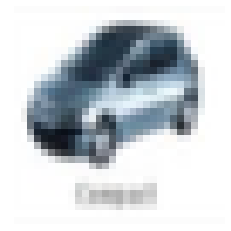

In [5]:
plt.imshow(X_train[1])
plt.axis('off')
plt.show()

In [6]:
y_train[1][0]

1

In [7]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
class_names[y_train[1][0]]

'automobile'

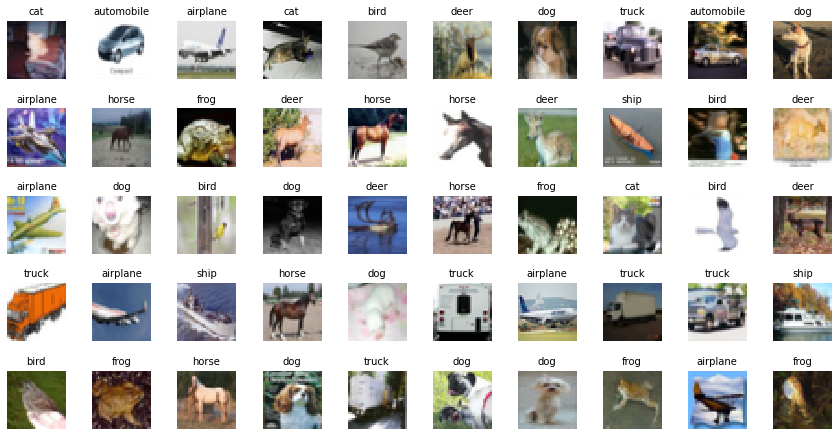

In [8]:
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(X_train[index], interpolation='nearest')
        plt.axis('off')
        plt.title(class_names[y_train[index][0]], fontsize=10)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [9]:
raw_adversarial_examples = adversarial_examples

scaler = StandardScaler()
#scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], 32*32*3))
X_test = scaler.transform(X_test.reshape(X_test.shape[0], 32*32*3))
#X_valid = scaler.transform(X_valid.reshape(X_valid.shape[0], 32*32*3))
adversarial_examples = scaler.transform(adversarial_examples.reshape(adversarial_examples.shape[0], 32*32*3))
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
#X_valid = X_valid.reshape(X_valid.shape[0], 32, 32, 3)
adversarial_examples = adversarial_examples.reshape(adversarial_examples.shape[0], 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


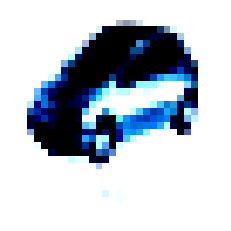

In [10]:
plt.imshow(X_train[1])
plt.axis('off')
plt.show()

In [11]:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [12]:
model = keras.models.Sequential()
model.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(32,32,3)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# happen a problem when not using Dropout.

model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)        

In [13]:
%%time
generator = ImageDataGenerator(shear_range=0.2, zoom_range=0.2, rotation_range=15, horizontal_flip=True)
iterator = generator.flow(X_train, y_train, batch_size=512)
generator.fit(X_train)

MODEL_DIR_PATH = 'cnn_model/'
if not os.path.exists(MODEL_DIR_PATH):
    os.mkdir(MODEL_DIR_PATH)
model_path = MODEL_DIR_PATH + "{epoch:03d}-{accuracy:.4f}.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='accuracy', save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
result = model.fit_generator(iterator, steps_per_epoch=len(X_train)/32, epochs=100, validation_data=[X_test, y_test], shuffle=True, callbacks=[checkpoint, early_stopping])
#result = model.fit(X_train, y_train, batch_size=1024, epochs=10, validation_data=[X_test, y_test], shuffle=True)

Epoch 1/100
1407/1406 [==============================] - 374s 266ms/step - loss: 0.9501 - accuracy: 0.6622 - val_loss: 0.6058 - val_accuracy: 0.8030
Epoch 2/100
1407/1406 [==============================] - 371s 264ms/step - loss: 0.5100 - accuracy: 0.8251 - val_loss: 0.4727 - val_accuracy: 0.8442
Epoch 3/100
1407/1406 [==============================] - 370s 263ms/step - loss: 0.4197 - accuracy: 0.8563 - val_loss: 0.4265 - val_accuracy: 0.8564
Epoch 4/100
1407/1406 [==============================] - 368s 262ms/step - loss: 0.3750 - accuracy: 0.8717 - val_loss: 0.4531 - val_accuracy: 0.8514
Epoch 5/100
1407/1406 [==============================] - 365s 259ms/step - loss: 0.3473 - accuracy: 0.8819 - val_loss: 0.3896 - val_accuracy: 0.8716
Epoch 6/100
1407/1406 [==============================] - 363s 258ms/step - loss: 0.3278 - accuracy: 0.8889 - val_loss: 0.4231 - val_accuracy: 0.8631
Epoch 7/100
1407/1406 [==============================] - 363s 258ms/step - loss: 0.3138 - accuracy: 0.8942

Epoch 56/100
1407/1406 [==============================] - 364s 259ms/step - loss: 0.2615 - accuracy: 0.9236 - val_loss: 0.5829 - val_accuracy: 0.8740
Epoch 57/100
1407/1406 [==============================] - 364s 259ms/step - loss: 0.2666 - accuracy: 0.9224 - val_loss: 0.5161 - val_accuracy: 0.8786
Wall time: 5h 46min 26s


In [14]:
result.params

{'epochs': 100,
 'steps': 1406.25,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

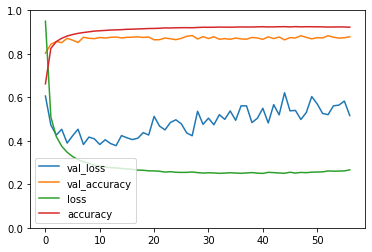

In [15]:
pd.DataFrame(result.history).plot()
plt.gca().set_ylim(0,1)
plt.show()

In [16]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 135us/step


[0.5160876913785934, 0.878600001335144]

In [17]:
predictions = model.predict(adversarial_examples)

In [18]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i][0], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i][0]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

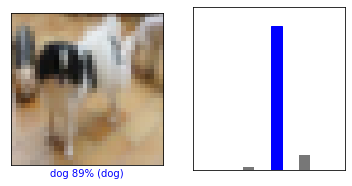

In [19]:
i = 19
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, adversarial_labels, raw_adversarial_examples)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  adversarial_labels)
plt.show()

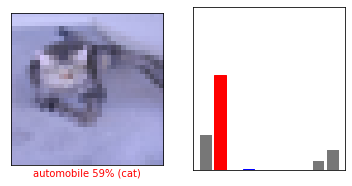

In [20]:
i = 100
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, adversarial_labels, raw_adversarial_examples)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  adversarial_labels)
plt.show()

In [21]:
# 분류기 성능 올리기
# uniform noise, image back-prop, FGSM, autoencoder, randomization layers 구현하기
# transfer learning으로 모델 옮기기